In [95]:
import numpy as np
import batman
import corner
import argparse
import exoparams
import json
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from os import environ
from pandas import DataFrame
from scipy import special
from sklearn.externals import joblib
from functools import partial
from lmfit import Parameters, Minimizer, report_errors
from multiprocessing import cpu_count, Pool
from scipy import spatial
from statsmodels.robust import scale
from time import time
from warnings import filterwarnings
filterwarnings('ignore')

# SYNOD methods and assisting routines:
import synod
from synod import utils
from synod import models
from synod import bliss
from synod import krdata as kr
from synod import pld

In [60]:
# Global constants.
y,x = 0,1
ppm = 1e6
day_to_seconds = 86400
zero = 0.0

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fit_type = {True: 'mcmc', False:'mle'}

plt.rcParams['figure.dpi'] = 300

In [61]:
planet_name = 'qatar2_planet_params.json'
# method = 'bliss'
method = 'krdata'
# method = 'pld'

channel = 'ch2'
staticRad = 2.5
varRad = 0.0
dataDir = '/Users/jonathan/Research/Planets/PhaseCurves/' + 'qatar2_full_output_for_pipeline_{}_{:.1f}_{:.1f}.joblib.save'.format(channel, staticRad, varRad)

x_bin_size = 0.005
y_bin_size = 0.005
do_mcmc = False

In [62]:
# transit_type='secondary'
x_sigma_range = 4
y_sigma_range = 4
f_sigma_range = 4

In [63]:
init_u1, init_u2, init_u3, init_u4, init_fpfs = None, None, None, None, None

if planet_name[-5:] == '.json':
    with open(planet_name, 'r') as file_in:
        planet_json = json.load(file_in)
    init_period = planet_json['period']
    init_t0     = planet_json['t0']
    init_aprs   = planet_json['aprs']
    init_inc    = planet_json['inc']
    
    if 'tdepth' in planet_json.keys():
        init_tdepth   = planet_json['tdepth']
    elif 'rprs' in planet_json.keys():
        init_tdepth   = planet_json['rprs']**2
    elif 'rp' in planet_json.keys():
        init_tdepth   = planet_json['rp']**2
    else:
        raise ValueError("Either `tdepth` or `rprs` or `rp` (in relative units) \
                            must be included in {}".format(planet_name))
    
    init_fpfs   = planet_json['fpfs'] if 'fpfs' in planet_json.keys() else 500 / ppm
    init_ecc    = planet_json['ecc']
    init_omega  = planet_json['omega']
    init_u1     = planet_json['u1'] if 'u1' in planet_json.keys() else None
    init_u2     = planet_json['u2'] if 'u2' in planet_json.keys() else None
    init_u3     = planet_json['u3'] if 'u3' in planet_json.keys() else None
    init_u4     = planet_json['u4'] if 'u4' in planet_json.keys() else None
    
    if 'planet name' in planet_json.keys():
        planet_name = planet_json['planet name']
    else:
        # Assume the json file name is the planet name
        #   This is a bad assumption; but it is one that users will understand
        print("'planet name' is not inlcude in {};".format(planet_name), end=" ")
        planet_name = planet_name.split('.json')[0]
        print(" assuming the 'planet name' is {}".format(planet_name))
else:
    init_period, init_t0, init_aprs, init_inc, init_tdepth, init_ecc, init_omega = exoparams_to_lmfit_params(planet_name)

init_fpfs = 50 / ppm if init_fpfs is None else init_fpfs
init_u1   = 0.1 if init_u1 is None else init_u1
init_u2   = 1e-6 if init_u2 is None else init_u2
init_u3   = 1e-6 if init_u3 is None else init_u3
init_u4   = 1e-6 if init_u4 is None else init_u4

In [64]:
print('Acquiring Data')

data_in = utils.setup_inputs_from_file(dataDir, x_bin_size=x_bin_size, y_bin_size=y_bin_size, xSigmaRange=x_sigma_range, 
                                       ySigmaRange=y_sigma_range, fSigmaRange=f_sigma_range, flux_key='phots', 
                                       time_key='times', flux_err_key='noise', eff_width_key = 'npix', 
                                       pld_coeff_key = 'pld', ycenter_key='ycenters', xcenter_key='xcenters', 
                                       ywidth_key='ywidths', xwidth_key='xwidths', method=method)

fluxes, times, flux_errs, npix, pld_intensities, xcenters, ycenters, xwidths, ywidths, \
    knots, nearIndices, keep_inds, ind_kdtree, gw_kdtree = data_in

# Only use the valid values
fluxes = fluxes[keep_inds]
times = times[keep_inds]
flux_errs = flux_errs[keep_inds]
npix = npix[keep_inds]
xcenters = xcenters[keep_inds]
ycenters = ycenters[keep_inds]
xwidths = xwidths[keep_inds]
ywidths = ywidths[keep_inds]

# Normalize pld pixel values
if method.lower() == 'pld':
    pldints = [pix[keep_inds] for pix in pld_intensities]
    pld_intensities = pld.normalize_pld(np.array(pldints))

# Normalize fluxes and flux errors around 1
flux_errs = flux_errs/np.median(fluxes)
fluxes = fluxes/np.median(fluxes)

Acquiring Data
Setting up inputs for krdata.
Setting up KRDATA


In [65]:
print('Fixing Time Stamps')
len_init_t0 = len(str(int(init_t0)))
len_times = len(str(int(times.mean())))

# Check if `init_t0` is in JD or MJD
if len_init_t0 == 7 and len_times != 7:
    if len_times == 5:
        init_t0 = init_t0 - 2400000.5
    elif len_times == 4:
        init_t0 = init_t0 - 2450000.5
    else:
        raise ValueError('The `init_t0` is {} and `times.mean()` is {}'.format(int(init_t0), int(times.mean())))

# Check if `init_t0` is in MJD or Simplified-MJD
if len(str(int(init_t0))) > len(str(int(times.mean()))): init_t0 = init_t0 - 50000

Fixing Time Stamps


In [66]:
print('Initializing Parameters')
initialParams = Parameters()
initialParams.add_many(
    ('period', init_period, False),
    ('deltaTc', 1e-6, True, -0.05, 0.05),
    ('deltaEc', 1e-6, True, -0.05, 0.05),
    ('inc', init_inc, False, 80.0, 90.),
    ('aprs', init_aprs, False, 0.0, 100.),
    ('tdepth', init_tdepth, True, 0.0, 0.3 ),
    ('edepth', init_fpfs, False, 0.0, 0.1),
    ('ecc', init_ecc, False, 0.0, 1.0 ),
    ('omega', init_omega, False, -180, 180 ),
    ('u1', init_u1 , True, 0.0, 1.0 ),
    ('u2', init_u2 , True, 0.0, 1.0 ),
    # ('u2', 0.0 , False, 0.0, 1.0 ),
    ('cosAmp', 10e-3, True, 0, 1),
    ('cosPhase', 1e-6, True, 0.0, np.pi),
    ('night_flux', 1e-6, True, 0.0, 1.0),
    ('tCenter', init_t0 , False),
    ('intercept', 1.0 , 0, 2, True),
    ('slope', 1e-6, True),
    ('curvature', 0.0 , False))

Initializing Parameters


In [67]:
phase = utils.compute_phase(times, init_t0, init_period)

#initialParams, transit_indices = models.add_line_params(initialParams, phase=phase, times=times, transitType=transit_type)
transit_indices = np.array([[0,len(times)]])

if method.lower() == 'pld':
    print('Initializing PLD coefficients.')
    initialParams = models.add_pld_params(initialParams, fluxes=fluxes, pld_intensities=pld_intensities)

In [68]:
partial_residuals  = partial(synod.residuals_func,
                             times = times,
                             xcenters = xcenters,
                             ycenters = ycenters,
                             fluxes = fluxes,
                             flux_errs = flux_errs,
                             knots = knots,
                             nearIndices = nearIndices,
                             keep_inds = keep_inds,
                             ind_kdtree = ind_kdtree,
                             pld_intensities = pld_intensities,
                             method = method.lower(),
                             gw_kdtree = gw_kdtree,
                             transit_indices = None,
                             x_bin_size = x_bin_size,
                             y_bin_size = y_bin_size, 
                             include_transit = True, 
                             include_eclipse = True, 
                             include_phase_curve = True, 
                             include_polynomial = True,
                             eclipse_option = 'trapezoid')

In [73]:
time_stamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")

'20180906130941'

In [80]:

print('Fitting the Model')
# Setup up the call to minimize the residuals (i.e. ChiSq)
# with Pool(cpu_count()) as pool:
mle0  = Minimizer(partial_residuals, initialParams)#, pool=pool)

start = time()
fitResult = mle0.leastsq() # Go-Go Gadget Fitting Routine
print("LMFIT operation took {} seconds".format(time()-start))

joblib.dump(fitResult, '{}_{}_{}_{}_{}_{}_fit_residuals_physics_{}.joblib.save'.format(planet_name, channel, staticRad, varRad, method, 
                                                                    fit_type[False], time_stamp))

['Qatar-2 b_ch2_2.5_0.0_krdata_mle_fit_residuals_physics_20180906131338.joblib.save']

In [81]:
report_errors(fitResult.params)

[[Variables]]
    period:      1.337117 (fixed)
    deltaTc:     1.0000e-06 (init = 1e-06)
    deltaEc:     1.0000e-06 (init = 1e-06)
    inc:         88.99 (fixed)
    aprs:        6.51466 (fixed)
    tdepth:      0.02658960 (init = 0.0266587)
    edepth:      0.002441907 (fixed)
    ecc:         0 (fixed)
    omega:       180 (fixed)
    u1:          0.15946022 (init = 0.1)
    u2:          1.5432e-07 (init = 0.1)
    cosAmp:      0.00148527 (init = 0.01)
    cosPhase:    0.12125439 (init = 1e-06)
    night_flux:  9.6409e-04 (init = 1e-06)
    tCenter:     57249.7 (fixed)
    intercept:   1 (fixed)
    slope:       0.00122600 (init = 1e-06)
    curvature:   0 (fixed)


In [82]:
print('Establishing the Best Fit Solution')

bf_model_set = synod.generate_best_fit_solution(fitResult.params, #initialParams, #
                                                times = times, 
                                                xcenters = xcenters, 
                                                ycenters = ycenters, 
                                                fluxes = fluxes, 
                                                knots = knots, 
                                                keep_inds = keep_inds, 
                                                method = method, 
                                                nearIndices = nearIndices, 
                                                ind_kdtree = ind_kdtree, 
                                                gw_kdtree = gw_kdtree, 
                                                pld_intensities = pld_intensities, 
                                                x_bin_size = x_bin_size, 
                                                y_bin_size = y_bin_size, 
                                                eclipse_option = 'trapezoid')

bf_full_model = bf_model_set['full_model']
bf_line_model = bf_model_set['line_model']
bf_physical_model = bf_model_set['physical_model']
bf_sensitivity_map = bf_model_set['sensitivity_map']
bf_transit_model = bf_model_set['transit_model']
bf_eclipse_model = bf_model_set['eclipse_model']
bf_phase_curve_model = bf_model_set['phase_curve_model']

Establishing the Best Fit Solution


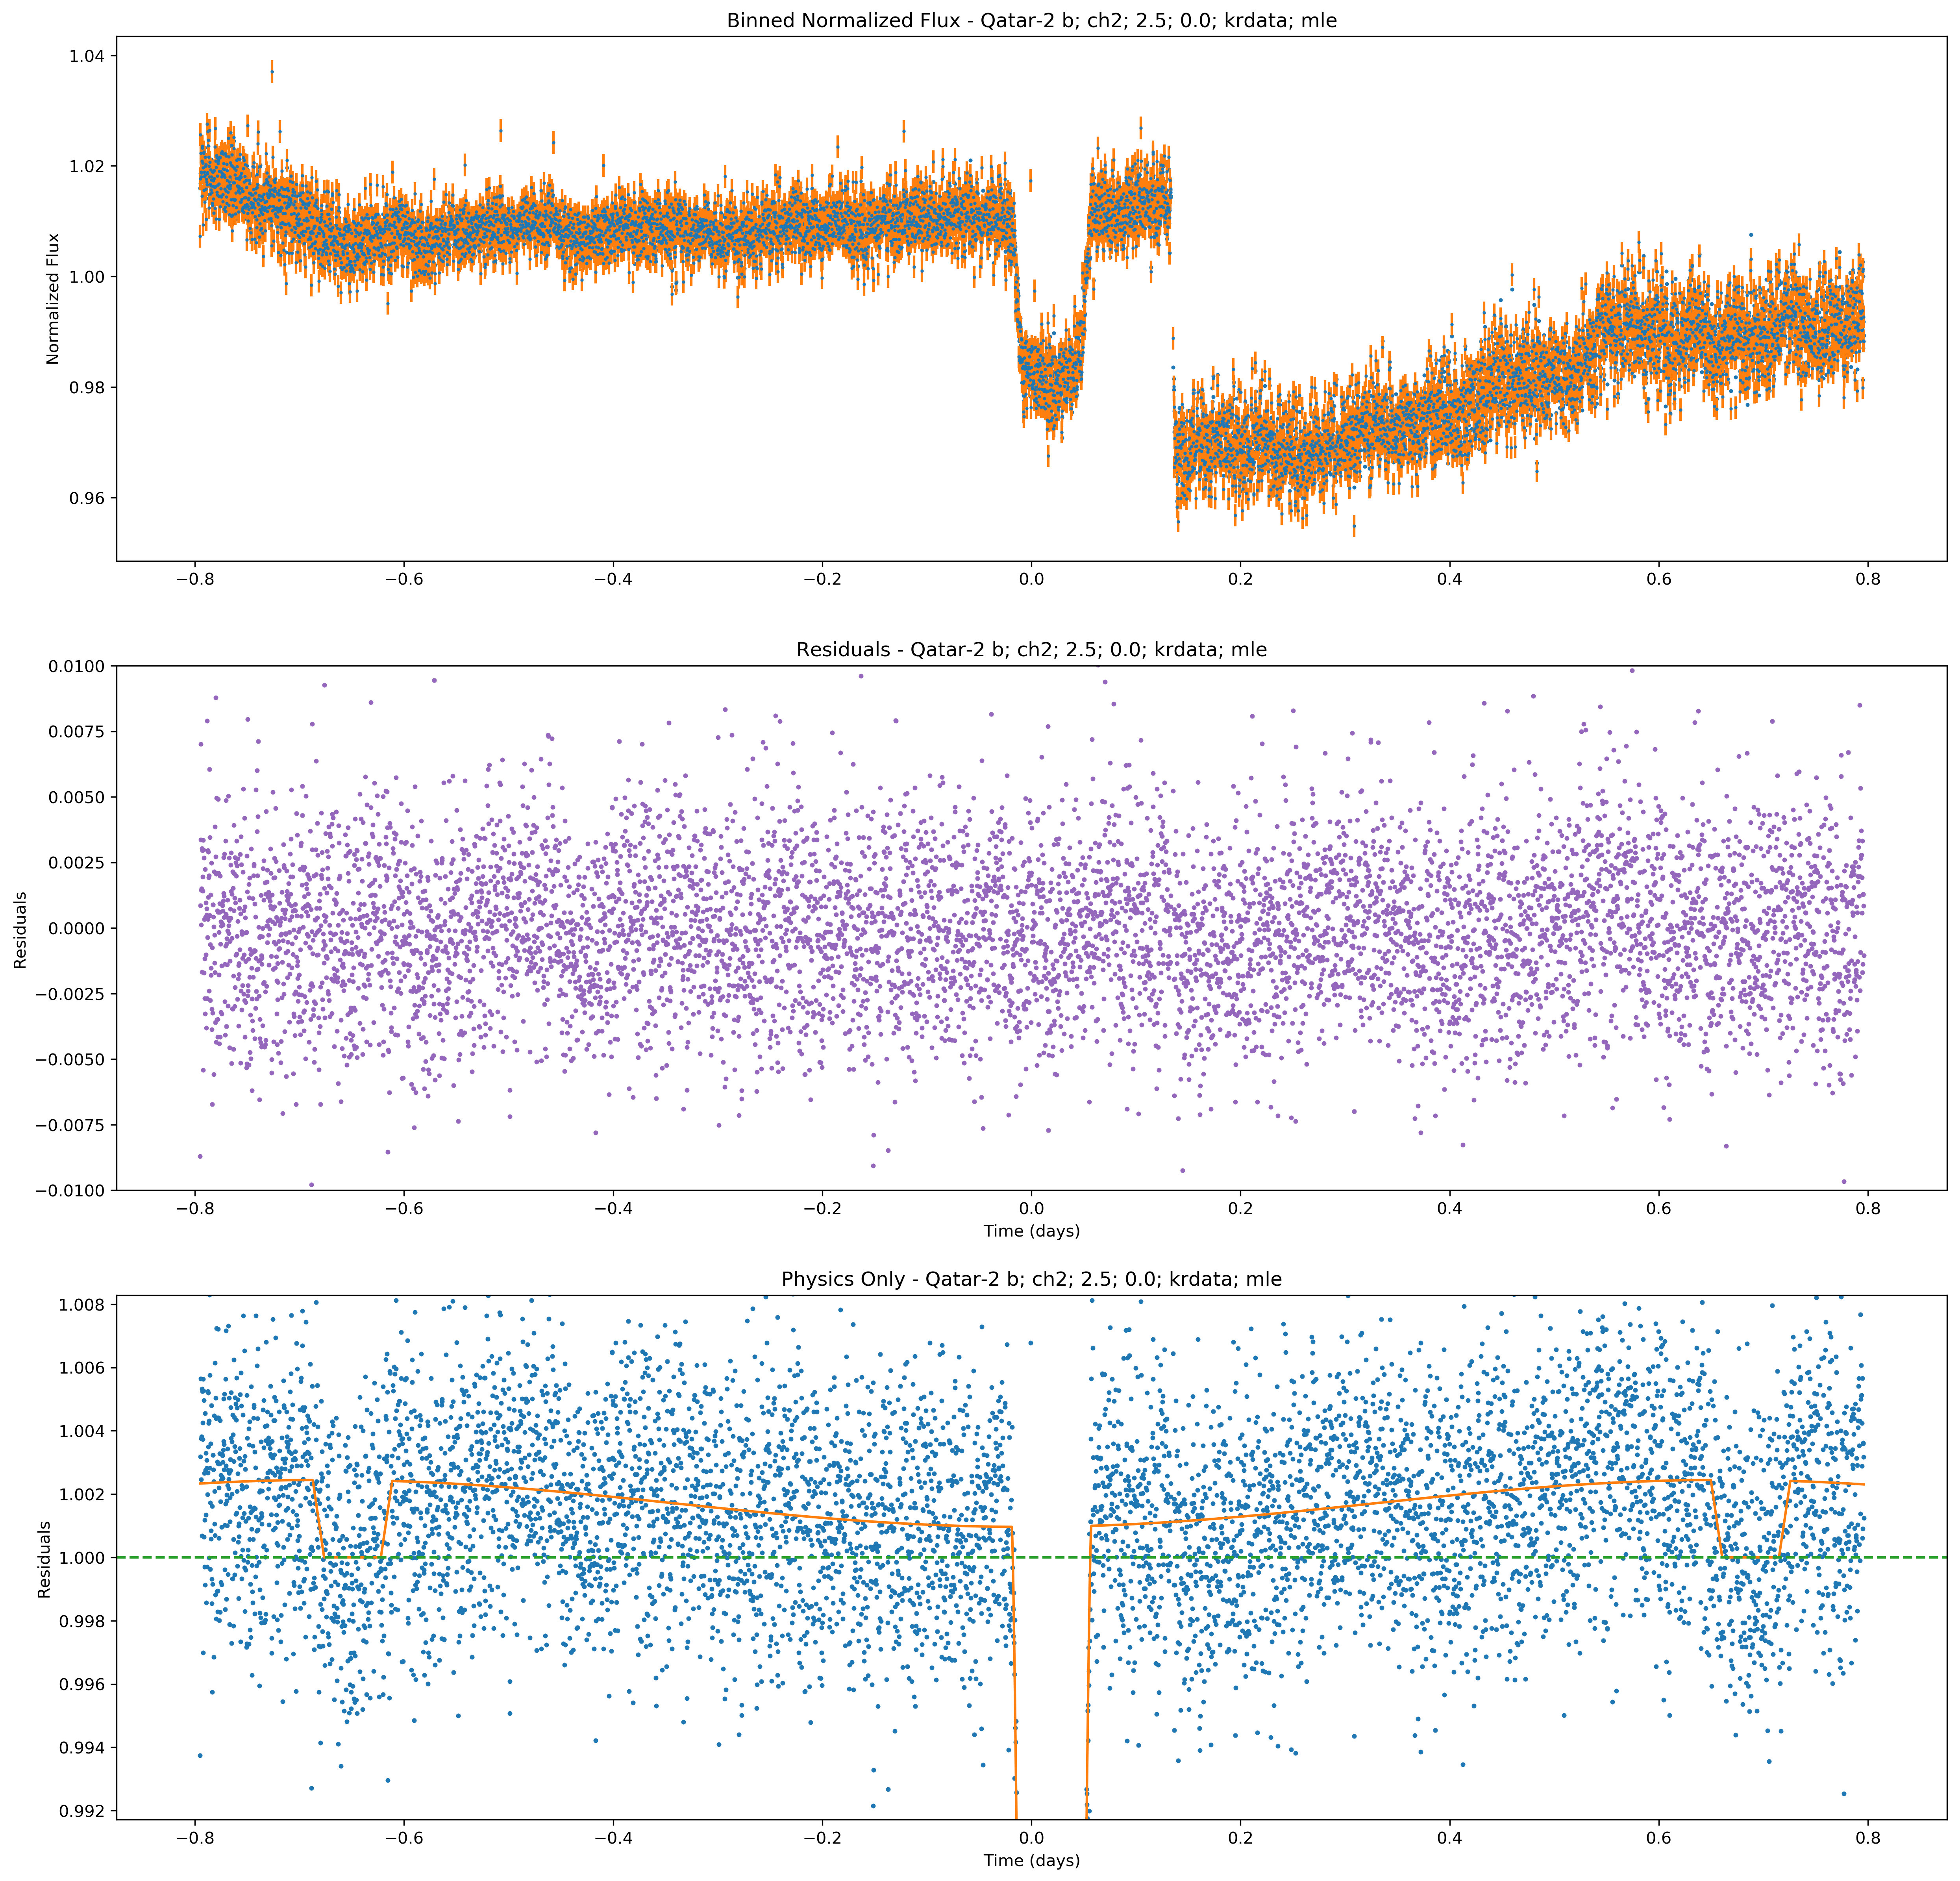

In [83]:
bin_size = 10

times_binned = utils.bin_data(times, bin_size = bin_size)
xcenters_binned = utils.bin_data(xcenters, bin_size = bin_size)
ycenters_binned = utils.bin_data(ycenters, bin_size = bin_size)
fluxes_binned = utils.bin_data(fluxes, bin_size = bin_size)
flux_errs_binned = utils.bin_data(flux_errs, bin_size = bin_size) / np.sqrt(bin_size)
bf_full_model_binned = utils.bin_data(bf_full_model, bin_size = bin_size)
bf_physical_model_binned = utils.bin_data(bf_physical_model, bin_size = bin_size)
bf_line_model_binned = utils.bin_data(bf_line_model, bin_size = bin_size)
phase_binned = utils.bin_data(phase, bin_size = bin_size)
bf_sensitivity_map_binned = utils.bin_data(bf_sensitivity_map, bin_size = bin_size)

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fit_type = {True: 'mcmc', False:'mle'}

plt.figure(figsize=(20,20))

plt.subplot2grid((3,1),(0,0))
plt.scatter(times_binned - times.mean(), bf_full_model_binned, color=color_cycle[0], s=2, label='Binned Normalized Flux')
plt.errorbar(times_binned - times.mean(), fluxes_binned, yerr=flux_errs_binned, ecolor = color_cycle[1],fmt='o', ms=1, label='Full MLE Fitting Model')
plt.title('Binned Normalized Flux - {}; {}; {}; {}; {}; {}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
plt.ylabel('Normalized Flux')

plt.subplot2grid((3,1),(1,0))
plt.title('Residuals - {}; {}; {}; {}; {}; {}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
plt.scatter(times_binned - times.mean(), fluxes_binned-bf_full_model_binned, s=3.5, color=color_cycle[4])
plt.xlabel('Time (days)')
plt.ylabel('Residuals')
plt.ylim(-0.01,0.01)

nSig = 3
std_res = np.std(fluxes_binned-bf_full_model_binned)

plt.subplot2grid((3,1),(2,0))
plt.title('Physics Only - {}; {}; {}; {}; {}; {}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
plt.scatter(times_binned - times.mean(), fluxes_binned / bf_sensitivity_map_binned / bf_line_model_binned, s=3.5, color=color_cycle[0])
plt.plot(times_binned - times.mean(), bf_physical_model_binned / bf_line_model_binned, color=color_cycle[1])
plt.xlabel('Time (days)')
plt.ylabel('Residuals')
plt.axhline(1.0, ls='--', color=color_cycle[2])
plt.ylim(1-nSig * std_res,1+nSig * std_res)

plt.savefig('{}_{}_{}_{}_{}_{}_fit_residuals_physics_{}.png'.format(planet_name, channel, staticRad, varRad, method, fit_type[False], time_stamp))

In [88]:
nSig = 10
do_mcmc=True
if do_mcmc:
    print('Setting MCMC up.')
    mle0.params.add('f', value=1, min=0.001, max=2)
    
    def logprior_func(p):
        return 0
    
    def lnprob(p):
        logprior = logprior_func(p)
        if not np.isfinite(logprior):
            return -np.inf

        resid = partial_residuals(p)
        s = p['f']
        resid *= 1 / s
        resid *= resid
        resid += np.log(2 * np.pi * s**2)
        return -0.5 * np.sum(resid) + logprior
    
    mini  = Minimizer(lnprob, mle0.params)
    
    n_steps = 200
    n_walkers = 100
    n_burn = int(n_steps*0.2)
    n_thin = 10
    n_temps = 1
    pos = None
    reuse_sampler = False
    n_workers = cpu_count()
    # float_behaviour = 'posterior'
    is_weighted = True
    seed = None# 42
    
    start = time()
    
    print('MCMC routine in progress...')
    res   = mini.emcee(params=mle0.params, steps=n_steps, nwalkers=n_walkers, burn=n_burn, thin=n_thin, ntemps=n_temps,
                       pos=pos, reuse_sampler=reuse_sampler, workers=n_workers, # float_behavior=float_behavior,
                       is_weighted=is_weighted, seed=seed)
    
    print("MCMC operation took {} seconds".format(time()-start))
    
    joblib.dump(res, 'emcee_{}_T0E0_{}steps_{}.joblib.save'.format(method, n_steps, time_stamp))
    
    report_errors(res.params)

Setting MCMC up.
MCMC routine in progress...
MCMC operation took 539.5129861831665 seconds
[[Variables]]
    period:      1.337117 (fixed)
    deltaTc:     7.7130e-07 +/- 5.7938e-07 (75.12%) (init = 1e-06)
    deltaEc:     9.3136e-07 +/- 5.3247e-07 (57.17%) (init = 1e-06)
    inc:         88.99 (fixed)
    aprs:        6.51466 (fixed)
    tdepth:      0.02696223 +/- 0.00163201 (6.05%) (init = 0.0266587)
    edepth:      0.010001 (fixed)
    ecc:         0 (fixed)
    omega:       180 (fixed)
    u1:          0.08642689 +/- 0.03100545 (35.87%) (init = 0.1)
    u2:          0.10675548 +/- 0.03940000 (36.91%) (init = 0.1)
    cosAmp:      0.00230379 +/- 0.00260599 (113.12%) (init = 0.01)
    cosPhase:    1.8443e-06 +/- 6.8719e-07 (37.26%) (init = 1e-06)
    night_flux:  3.3826e-07 +/- 3.1638e-07 (93.53%) (init = 1e-06)
    tCenter:     57249.7 (fixed)
    intercept:   1 (fixed)
    slope:       1.0567e-06 +/- 1.9593e-07 (18.54%) (init = 1e-06)
    curvature:   0 (fixed)
    f:           1

if do_mcmc: report_errors(res.params)

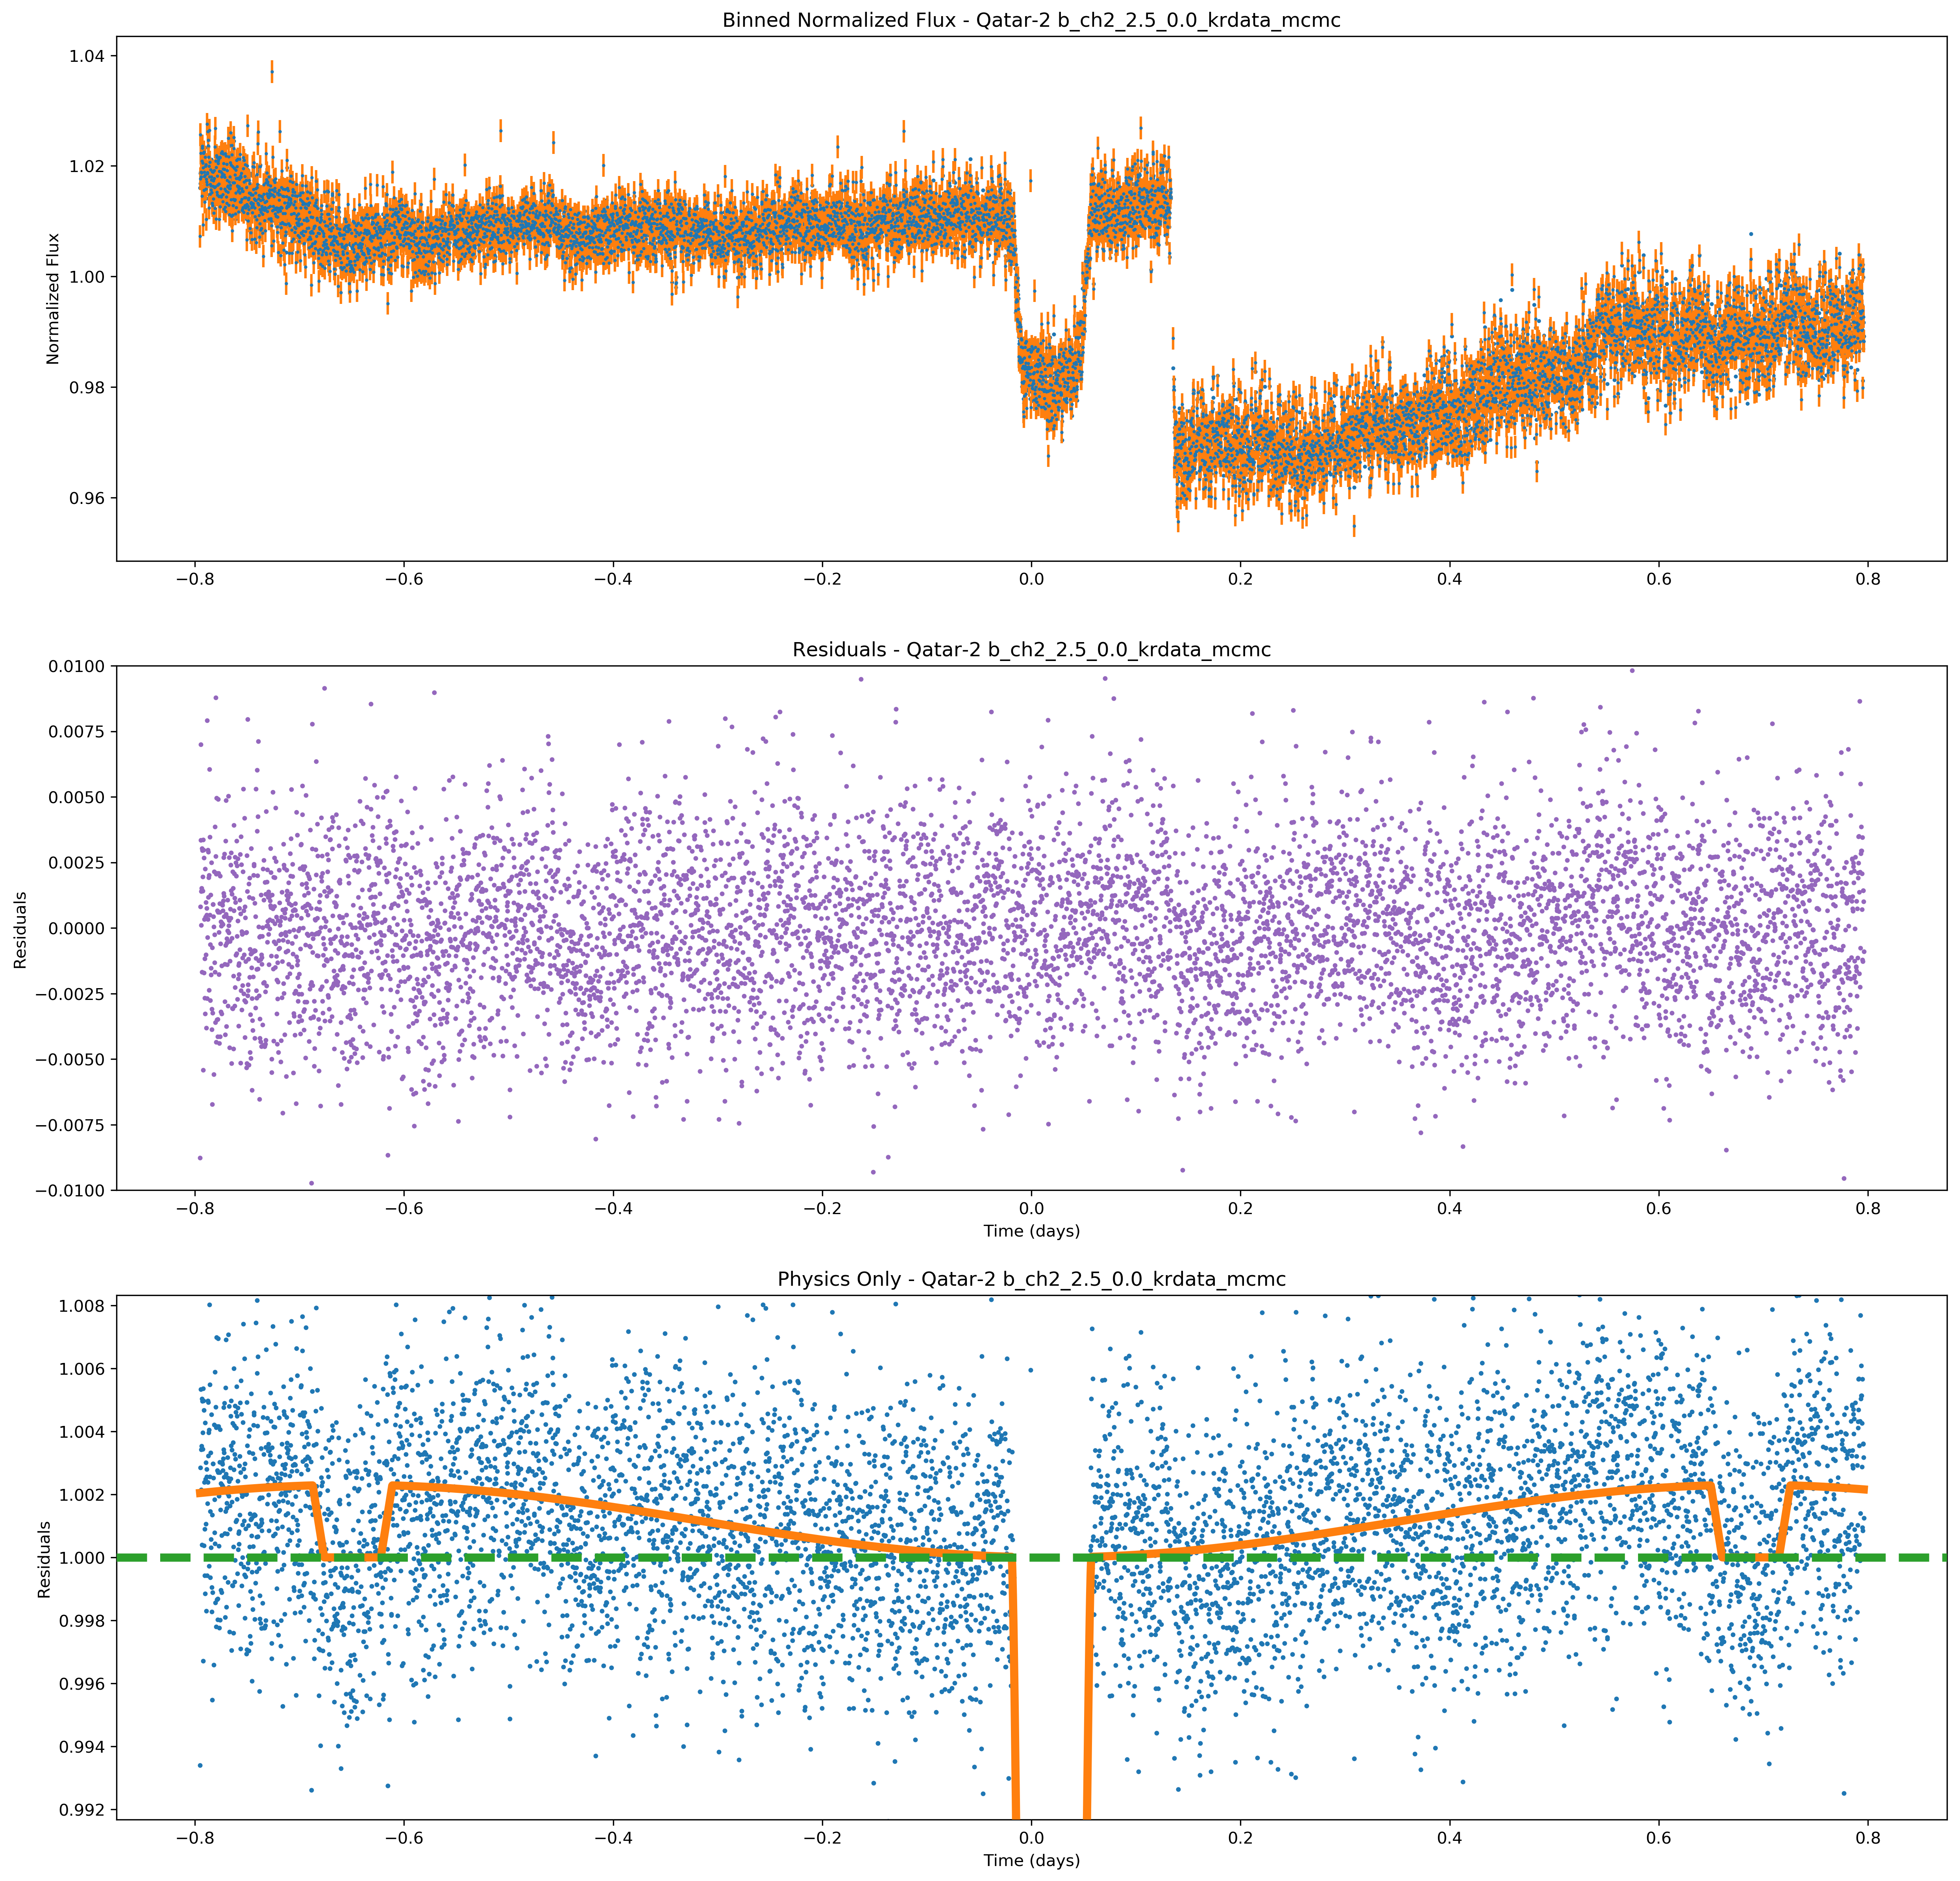

In [92]:
if do_mcmc:
    bf_model_set = synod.generate_best_fit_solution(res.params, 
                                                    times = times, 
                                                    xcenters = xcenters, 
                                                    ycenters = ycenters, 
                                                    fluxes = fluxes, 
                                                    knots = knots, 
                                                    keep_inds = keep_inds, 
                                                    method = method, 
                                                    nearIndices = nearIndices, 
                                                    ind_kdtree = ind_kdtree, 
                                                    gw_kdtree = gw_kdtree, 
                                                    pld_intensities = pld_intensities, 
                                                    x_bin_size = x_bin_size, 
                                                    y_bin_size = y_bin_size, 
                                                    transit_indices = transit_indices)
    
    bf_full_model = bf_model_set['full_model']
    bf_line_model = bf_model_set['line_model']
    bf_physical_model = bf_model_set['physical_model']
    bf_sensitivity_map = bf_model_set['sensitivity_map']
    bf_transit_model = bf_model_set['transit_model']
    bf_eclipse_model = bf_model_set['eclipse_model']
    bf_phase_curve_model = bf_model_set['phase_curve_model']
    
    bin_size = 10
    
    times_binned = utils.bin_data(times, bin_size = bin_size)
    xcenters_binned = utils.bin_data(xcenters, bin_size = bin_size)
    ycenters_binned = utils.bin_data(ycenters, bin_size = bin_size)
    fluxes_binned = utils.bin_data(fluxes, bin_size = bin_size)
    flux_errs_binned = utils.bin_data(flux_errs, bin_size = bin_size) / np.sqrt(bin_size)
    bf_full_model_binned = utils.bin_data(bf_full_model, bin_size = bin_size)
    bf_physical_model_binned = utils.bin_data(bf_physical_model, bin_size = bin_size)
    bf_line_model_binned = utils.bin_data(bf_line_model, bin_size = bin_size)
    phase_binned = utils.bin_data(phase, bin_size = bin_size)
    bf_sensitivity_map_binned = utils.bin_data(bf_sensitivity_map, bin_size = bin_size)
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fit_type = {True: 'mcmc', False:'mle'}
    
    plt.figure(figsize=(20,20))
    
    plt.subplot2grid((3,1),(0,0))
    plt.scatter(times_binned - times.mean(), bf_full_model_binned, color=color_cycle[0], s=2, label='Binned Normalized Flux')
    plt.errorbar(times_binned - times.mean(), fluxes_binned, yerr=flux_errs_binned, ecolor = color_cycle[1],fmt='o', ms=1, label='Full MCMC Fitting Model')
    plt.title('Binned Normalized Flux - {}_{}_{}_{}_{}_{}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
    plt.ylabel('Normalized Flux')
    
    plt.subplot2grid((3,1),(1,0))
    plt.title('Residuals - {}_{}_{}_{}_{}_{}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
    plt.scatter(times_binned - times.mean(), fluxes_binned-bf_full_model_binned, s=3.5, color=color_cycle[4])
    plt.xlabel('Time (days)')
    plt.ylabel('Residuals')
    plt.ylim(-0.01,0.01)
    
    nSig = 3
    std_res = np.std(fluxes_binned-bf_full_model_binned)
    
    plt.subplot2grid((3,1),(2,0))
    plt.title('Physics Only - {}_{}_{}_{}_{}_{}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
    plt.scatter(times_binned - times.mean(), fluxes_binned / bf_sensitivity_map_binned / bf_line_model_binned, s=3.5, color=color_cycle[0])
    plt.plot(times_binned - times.mean(), bf_physical_model_binned / bf_line_model_binned, color=color_cycle[1], lw=5, zorder=100)
    plt.xlabel('Time (days)')
    plt.ylabel('Residuals')
    plt.axhline(1.0, ls='--', color=color_cycle[2], lw=5, zorder=100)
    plt.ylim(1-nSig * std_res,1+nSig * std_res)
    
    plt.savefig('{}_{}_{}_{}_{}_{}_fit_residuals_physics_{}.png'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc], time_stamp))

In [100]:
ranges

[(-5.553395627291136e-06, -5.553395627291136e-06),
 (-3.3558381283286585e-06, -3.3558381283286585e-06),
 (0.016694337319427155, 0.016694337319427155),
 (-0.1241323122380102, -0.1241323122380102),
 (-0.012910462606620116, -0.012910462606620116),
 (-3.4513855941719673e-06, -3.4513855941719673e-06),
 (-1.442957311627822e-06, -1.442957311627822e-06),
 (0.9600942143683661, 0.9600942143683661)]

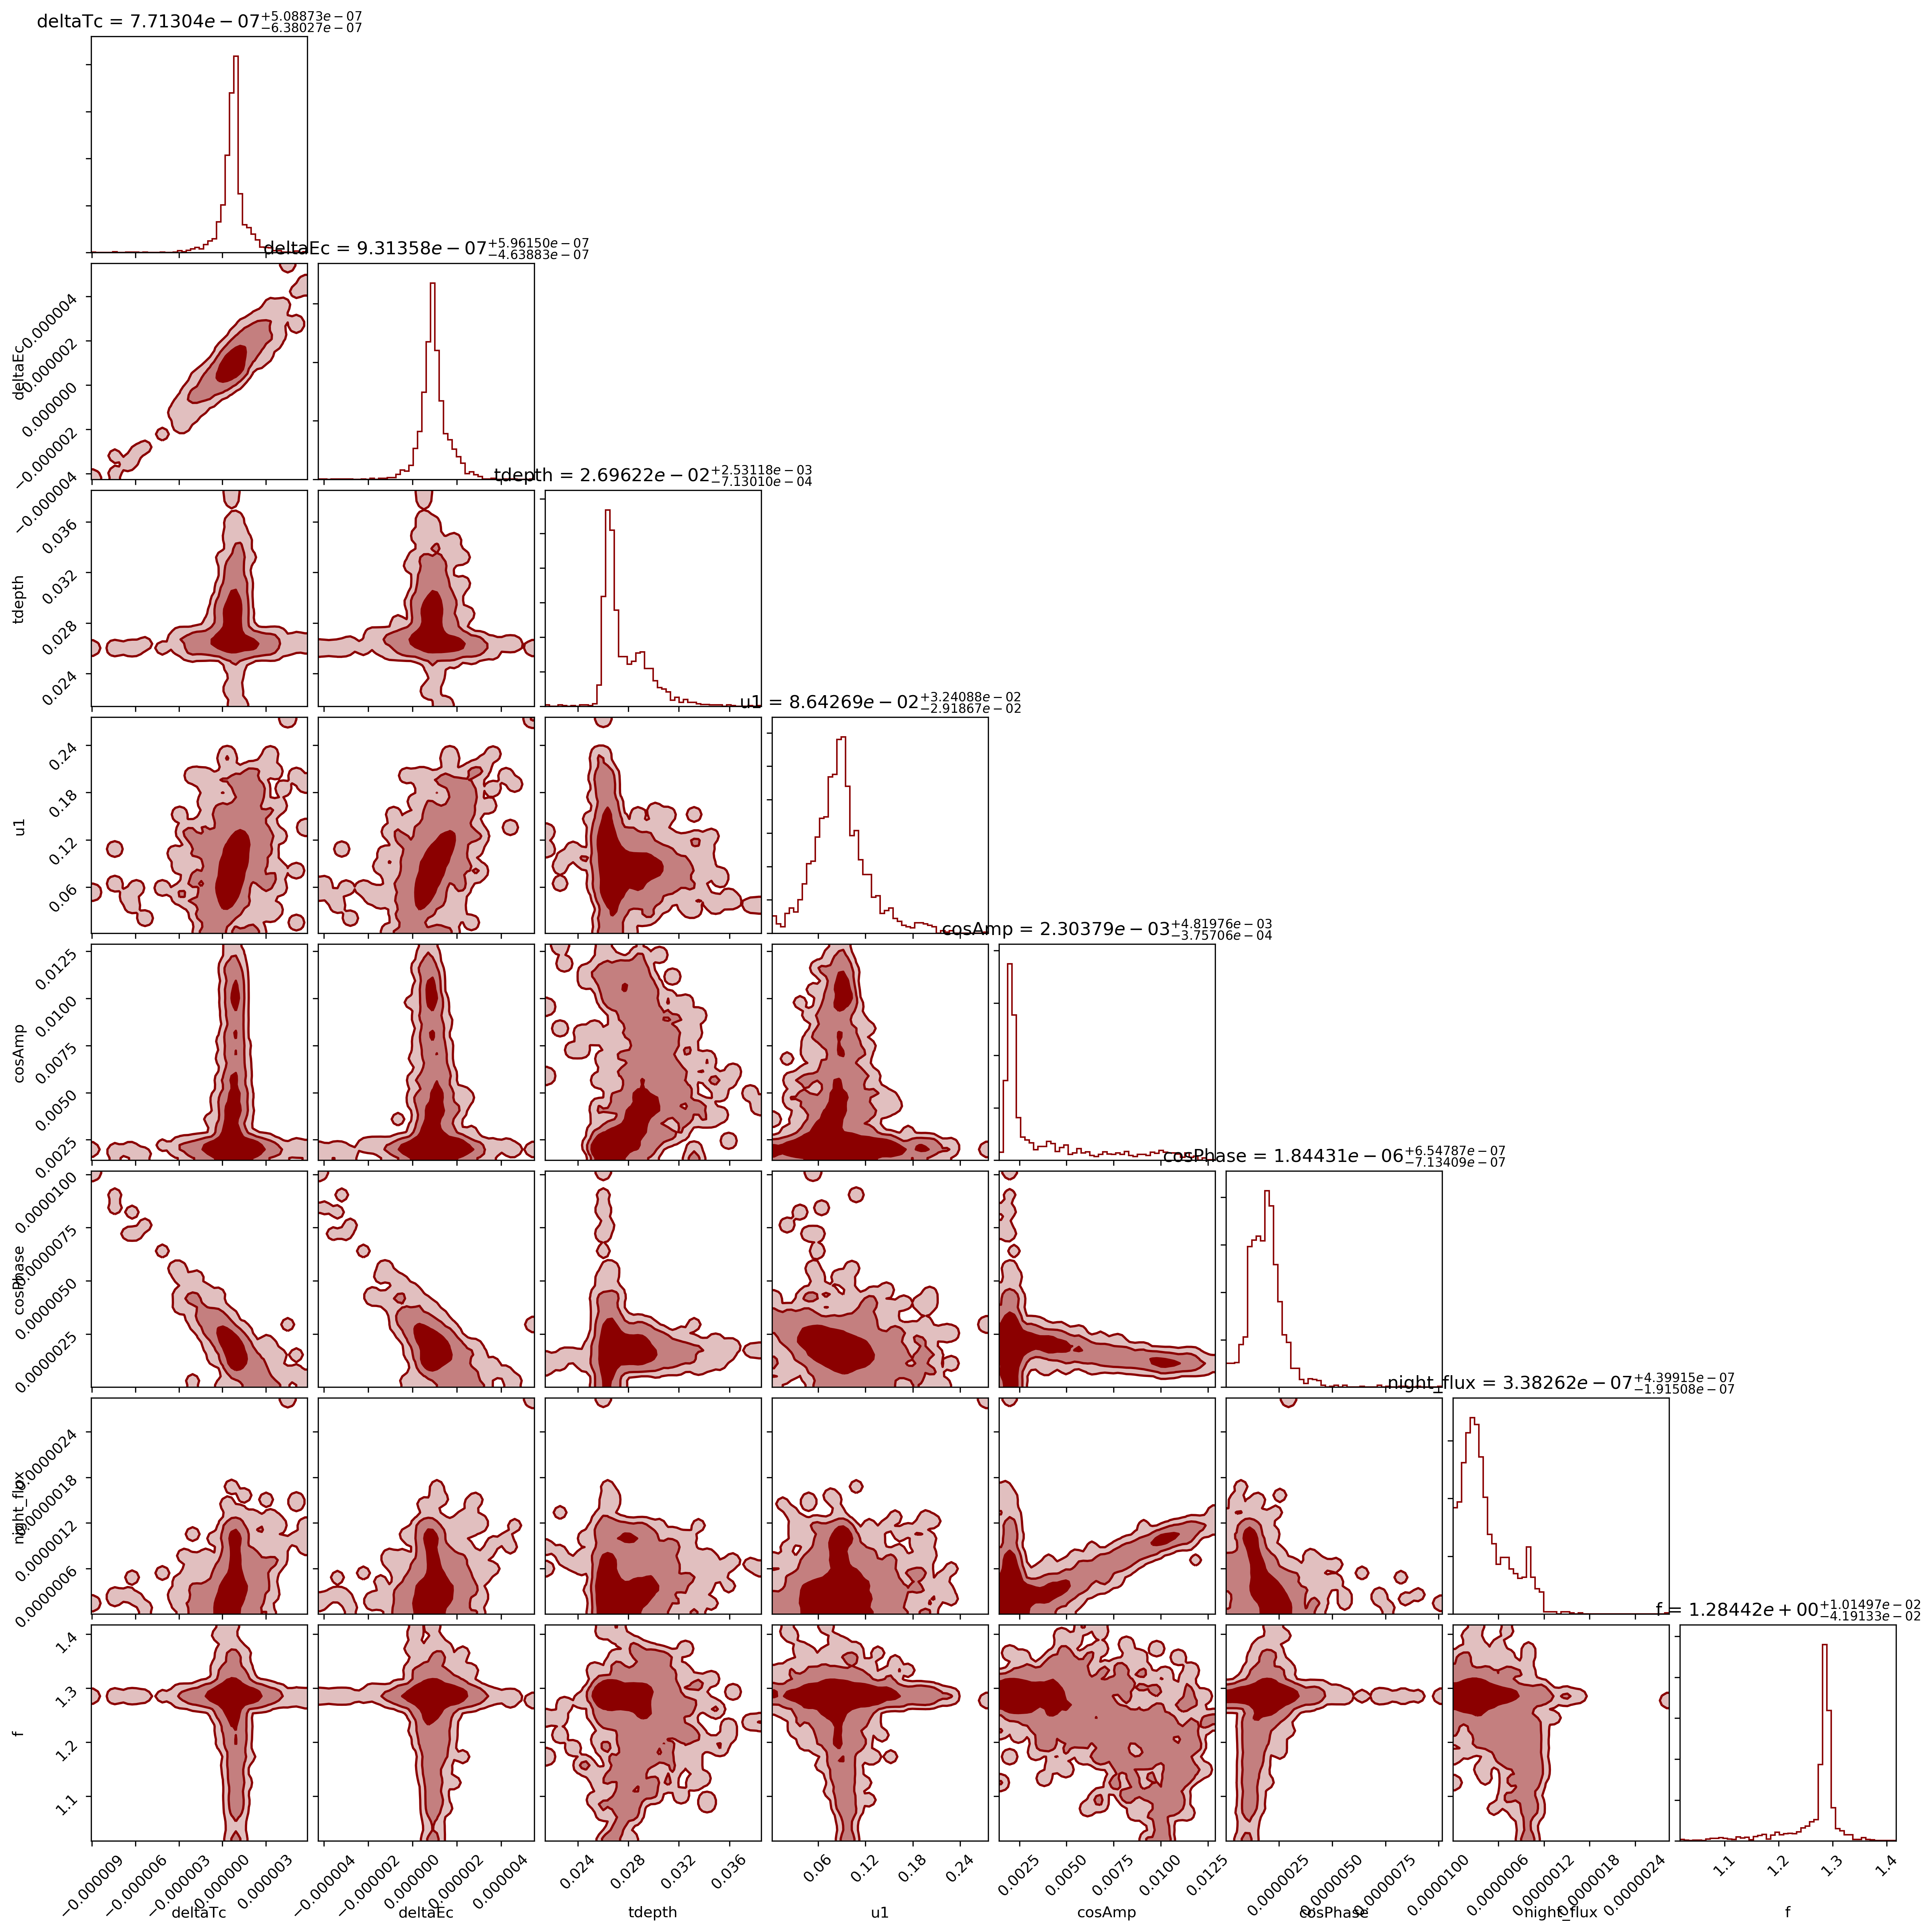

In [104]:
if do_mcmc:
    res_var_names = np.array(res.var_names)
    res_flatchain = np.array(res.flatchain)
    res_df = DataFrame(res_flatchain, columns=res_var_names)
    res_df = res_df.drop(['u2','slope'], axis=1)
    
    nSig = 6
    ranges = [(np.mean(val) - nSig*np.std(val), np.mean(val) - nSig*np.std(val)) for key,val in res_df.items()]
    # sigmaTc = np.std(res_df['deltaTc'])
    # meanTc = np.mean(res_df['deltaTc'])

    # sigmatd = np.std(res_df['tdepth'])
    # meantd = np.mean(res_df['tdepth'])

    # sigmau1 = np.std(res_df['u1'])
    # meanu1 = np.mean(res_df['u1'])

    # sigmau1 = np.std(res_df['u1'])
    # meanu1 = np.mean(res_df['u1'])

    # sigmaint = np.std(res_df['intcept'])
    # meanint = np.mean(res_df['intcept'])

    # sigmaf = np.std(res_df['f'])
    # meanf = np.mean(res_df['f'])
    
    corner.corner(res_df, color='darkred', 
                  plot_datapoints=False, bins=50, 
                  plot_density=False, smooth=True, 
                  fill_contours = True, 
                  levels=[0.68, 0.95, 0.997], show_titles=True, 
                  title_fmt = '0.5e')
                  # range = ranges
                  # range = [(meanTc-(6*sigmaTc), meanTc+(6*sigmaTc)), (meantd-(6*sigmatd), meantd+(6*sigmatd)), 
                  #          (meanu1-(6*sigmau1), meanu1+(6*sigmau1)), (meanint-(6*sigmaint), meanint+(6*sigmaint)), 
                  #          (meanf-(6*sigmaf), meanf+(6*sigmaf))]
                  # )
    
    plt.savefig('{}_{}_{}_{}_{}_{}_emcee_cornerplot_{}.png'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc], time_stamp))

# Source of Plotting Scripts

In [ ]:
bin_size = 10

times_binned = utils.bin_data(times, bin_size = bin_size)
xcenters_binned = utils.bin_data(xcenters, bin_size = bin_size)
ycenters_binned = utils.bin_data(ycenters, bin_size = bin_size)
fluxes_binned = utils.bin_data(fluxes, bin_size = bin_size)
flux_errs_binned = utils.bin_data(flux_errs, bin_size = bin_size) / np.sqrt(bin_size)
bf_full_model_binned = utils.bin_data(bf_full_model, bin_size = bin_size)
bf_physical_model_binned = utils.bin_data(bf_physical_model, bin_size = bin_size)
bf_line_model_binned = utils.bin_data(bf_line_model, bin_size = bin_size)
phase_binned = utils.bin_data(phase, bin_size = bin_size)
bf_sensitivity_map_binned = utils.bin_data(bf_sensitivity_map, bin_size = bin_size)

In [ ]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fit_type = {True: 'mcmc', False:'mle'}

plt.figure(figsize=(20,20))

plt.subplot2grid((3,1),(0,0))
plt.scatter(times_binned - times.mean(), bf_full_model_binned, color=color_cycle[0], s=2, legend='Binned Normalized Flux')
plt.errorbar(times_binned - times.mean(), fluxes_binned, yerr=flux_errs_binned, ecolor = color_cycle[1],fmt='o', ms=1, 'Full {} Fitting Model')
plt.title('Binned Normalized Flux - {}_{}_{}_{}_{}_{}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
plt.ylabel('Normalized Flux')

plt.subplot2grid((3,1),(1,0))
plt.title('Residuals - {}_{}_{}_{}_{}_{}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
plt.scatter(times_binned - times.mean(), fluxes_binned-bf_full_model_binned, s=3.5, color=color_cycle[4])
plt.xlabel('Time (days)')
plt.ylabel('Residuals')
plt.ylim(-0.01,0.01)

nSig = 3
std_res = np.std(fluxes_binned-bf_full_model_binned)

plt.subplot2grid((3,1),(2,0))
plt.title('Physics Only - {}_{}_{}_{}_{}_{}'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))
plt.scatter(times_binned - times.mean(), fluxes_binned / bf_sensitivity_map_binned / bf_line_model_binned, s=3.5, color=color_cycle[0])
plt.plot(times_binned - times.mean(), bf_physical_model_binned / bf_line_model_binned, color=color_cycle[1])
plt.xlabel('Time (days)')
plt.ylabel('Residuals')
plt.axhline(1.0, ls='--', color=color_cycle[2])
plt.ylim(1-nSig * std_res/ppm,1+nSig * std_res/ppm)

plt.savefig('{}_{}_{}_{}_{}_{}_fit_residuals_physics.png'.format(planet_name, channel, staticRad, varRad, method, fit_type[do_mcmc]))

Test Inputs Confirm Models Behave as Expected
----

Establishing the Best Fit Solution
349.97546744519605 600.0
445.3892009514959 600.0
526.2807930128677 600.0
580.3352324806888 600.0
599.3232207290866 600.0


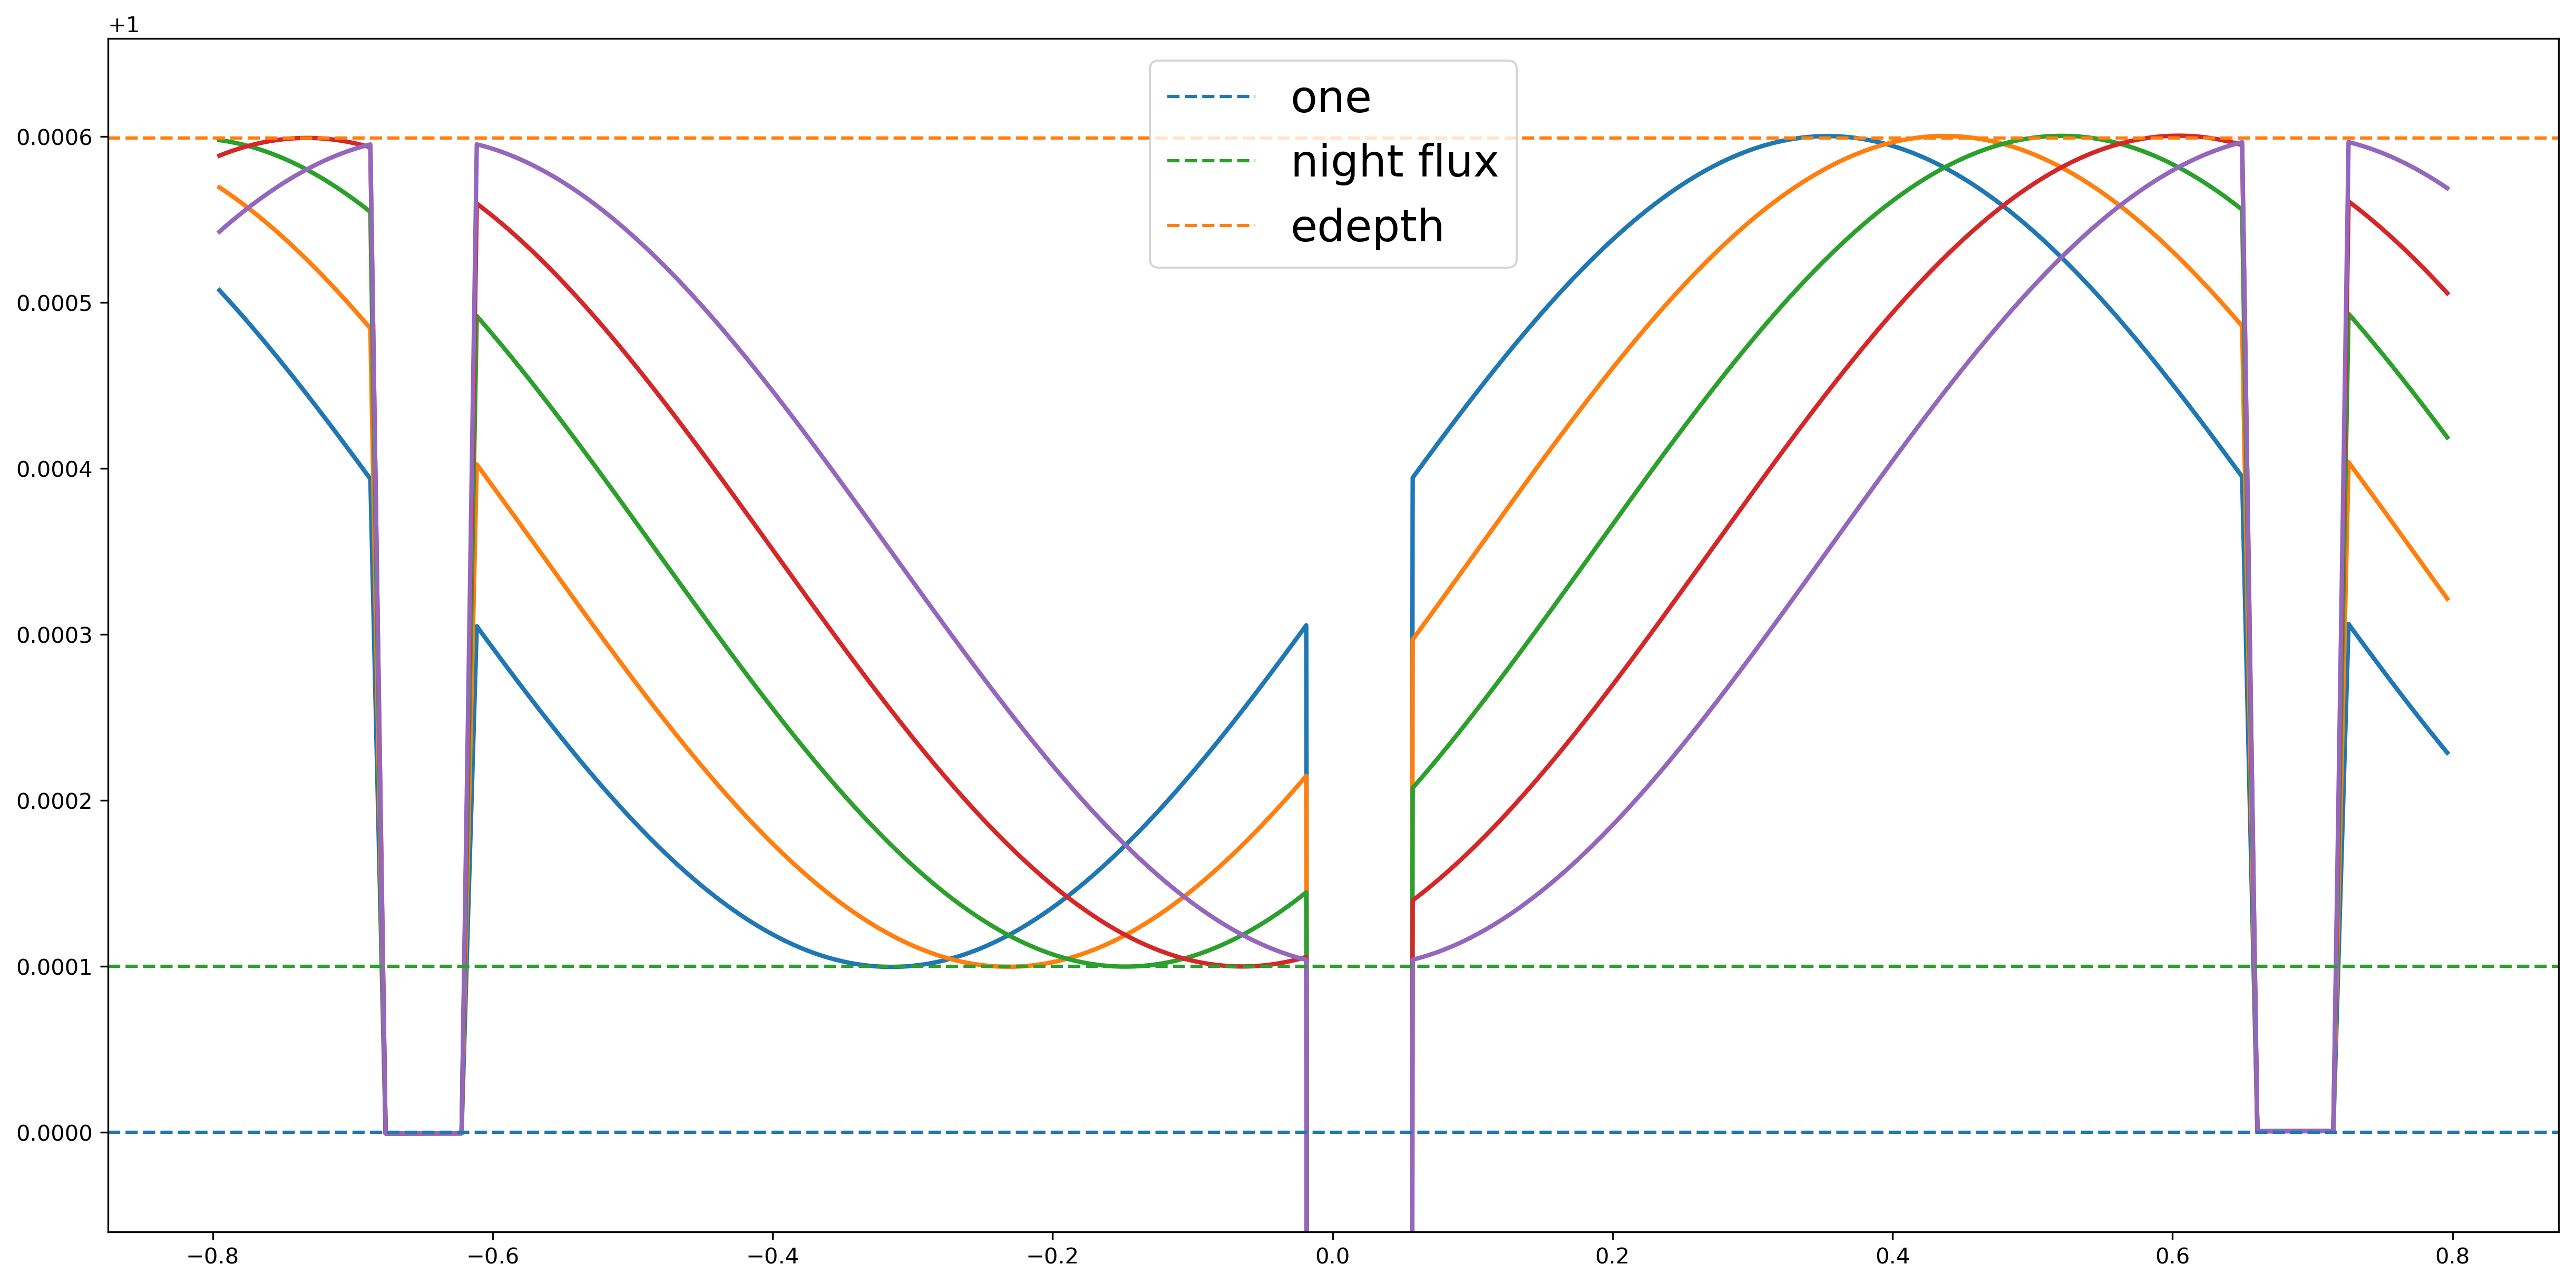

In [54]:
partial_residuals  = partial(synod.residuals_func,
                             times = times,
                             xcenters = xcenters,
                             ycenters = ycenters,
                             fluxes = fluxes,
                             flux_errs = flux_errs,
                             knots = knots,
                             nearIndices = nearIndices,
                             keep_inds = keep_inds,
                             ind_kdtree = ind_kdtree,
                             pld_intensities = pld_intensities,
                             method = method.lower(),
                             gw_kdtree = gw_kdtree,
                             transit_indices = None,
                             x_bin_size = x_bin_size,
                             y_bin_size = y_bin_size, 
                             include_transit = True, 
                             include_eclipse = True, 
                             include_phase_curve = True, 
                             include_polynomial = True)

test_pc_amp = 500 / ppm
test_nflux = 100 / ppm

initialParams = Parameters()
initialParams.add_many(
    ('period', init_period, False),
    ('deltaTc', 1e-6, True, -0.05, 0.05),
    ('deltaEc', 1e-6, True, -0.05, 0.05),
    ('inc', init_inc, False, 80.0, 90.),
    ('aprs', init_aprs, False, 0.0, 100.),
    ('tdepth', init_tdepth, True, 0.0, 0.3 ),
    ('edepth', test_pc_amp, False, 0.0, 0.1),
    ('ecc', init_ecc, False, 0.0, 1.0 ),
    ('omega', init_omega, False, -180, 180 ),
    ('u1', 0 , True, 0.0, 1.0 ),
    ('u2', 0 , True, 0.0, 1.0 ),
    ('cosAmp', test_pc_amp, True, 0, 1),
    ('cosPhase', np.pi/2, True, 0.0, np.pi),
    ('night_flux', test_nflux, True, 0.0, 1.0),
    ('tCenter', init_t0 , False),
    ('intercept', 1.0 , 0, 2, True),
    ('slope', 1e-6, True),
    ('curvature', 0.0 , False))

print('Establishing the Best Fit Solution')

model_set = synod.compute_full_model(initialParams, times, include_transit = True, 
                                        include_eclipse = True, include_phase_curve = True, 
                                        include_polynomial = True, eclipse_option = 'trapezoid',
                                        subtract_edepth = False, return_case = 'dict')

line_model = model_set['line_model']
physical_model = model_set['physical_model']
transit_model = model_set['transit_model']
eclipse_model = model_set['eclipse_model']
phase_curve_model = model_set['phase_curve_model']

plt.figure(figsize=(20,10))

for cosPhase in np.linspace(0,0.5*np.pi, 5)[::-1]:
    initialParams['cosPhase'].value = cosPhase
    model_now = partial_residuals(initialParams, testing_model=True);
    plt.plot(times-times.mean(), model_now, lw=2);#, label=initialParams['cosPhase'].value*np.pi);
    print(initialParams['edepth'].value*ppm, (test_nflux+test_pc_amp)*ppm)
    # plt.plot(times[::10]-times.mean(), model_now[::10], '.', ms=2);

plt.axhline(1.0, ls='--', color=color_cycle[0], label='one');
plt.axhline(1.0+initialParams['night_flux'].value, ls='--', color=color_cycle[2], label='night flux');
plt.axhline(1.0+initialParams['edepth'].value, ls='--', color=color_cycle[1], label='edepth');
plt.legend(loc=0, fontsize=20);
plt.ylim(1-0.1*initialParams['edepth'].value,1+1.1*initialParams['edepth'].value);

save_fig = False
if save_fig: plt.savefig('set_of_example_phase_curves_with_trapezoid_forced_eclise.png')